# Nonlinearities

In [1]:
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_moons

import torch
from torch import nn
from torchsummary import summary

(800, 2) (200, 2) (800,) (200,)


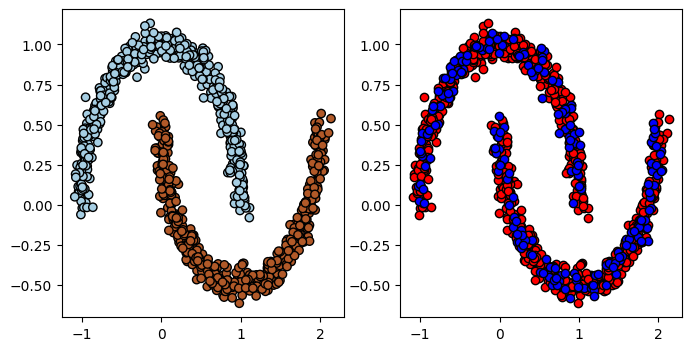

In [26]:
# Configuration options
num_classes = 2
X, y = make_moons(n_samples= 1000 , noise=0.05)

X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.20, random_state = 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

_, axes = plt.subplots (1,2, figsize=(8,4))

axes[0].scatter( X[:,0] , X[:,1] , c = y ,edgecolors = 'k', cmap='Paired')
axes[1].scatter( X_train[:,0] , X_train[:,1] , c="r",edgecolors = 'k')
axes[1].scatter( X_test[:,0] , X_test[:,1] , c="b",edgecolors = 'k')

In [16]:
# # Convert into greyscale
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [27]:
# Convert target classes to categorical ones
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (X_train.shape)
print(f'Feature shape: {input_shape}')

Feature shape: (800, 2)


In [28]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 2) (200, 2) (800, 2) (200, 2)


## Create a graph model

In [85]:
model = nn.Sequential(
    nn.Linear(2, 2), nn.Tanh()
    # nn.ReLU(),
    # nn.Linear(10, 2)
)

# model.cuda()  # Move model to GPU
summary(model, input_size=(2,), device='cpu')  # Use 'cuda' for summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]               6
              Tanh-2                    [-1, 2]               0
Total params: 6
Trainable params: 6
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Define loss function and optimizer

In [86]:
# loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

# model.cuda()
# loss.cuda()

## Train model

In [87]:
epochs = 800
batch_size = 200
losses = []

progress = tqdm(range( epochs ), ncols=110) #barrita de progreso (se pone en qué va a iterar)

for epoch in progress:
  #
  batch_losses = 0 #para acumular el error en cada epoca

  for batch_i in range(0, len(X_train), batch_size):
    #
    batch_X = X_train[ batch_i : batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    #conversion
    batch_X = torch.from_numpy(batch_X).to(torch.float32)#.cuda()
    batch_y = torch.from_numpy(batch_y).to(torch.float32)#.cuda()

    # 1.Zero the gradients
    optimizer.zero_grad() #reinicializar los gradientes

    # 2.Perform forward pass
    predictions = model( batch_X ) #model.forward() tambien es otra opcion

    # 3.Compute loss
    batch_loss = loss( batch_y , predictions )

    # 4.Perform backward pass
    batch_loss.backward() #calcular los gradientes
    #recordar que los gradientes se calculan con base al error

    # 5.Optimize parameters
    optimizer.step() #optimización de los parametros

    ## 6.Save stats #mostrar los errores acumulados y mostrar la barrita
    batch_losses += batch_loss.item()

  progress.set_description("Epoch [%d/%d] [Loss: %f] " % (epoch, epochs,
                                                                   batch_losses/(len(X_train)/batch_size)))

  losses.append(batch_losses/(len(X_train)/batch_size))


Epoch [799/800] [Loss: 0.090544] : 100%|███████████████████████████████████| 800/800 [00:04<00:00, 190.49it/s]


## Plot results

Text(0, 0.5, 'Loss (MSE)')

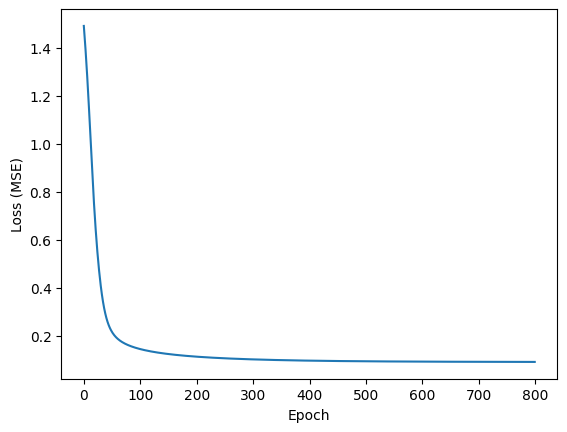

In [88]:
# import seaborn as sns

plt.plot(np.array(losses))
plt.xlabel("Epoch")
plt.ylabel('Loss (MSE)')

In [89]:
h_min, h_max = X_test[:,0].min()-0.2, X_test[:,0] .max()+0.2
v_min, v_max = X_test[:,1] .min()-0.1, X_test[:,1] .max()+0.1

# Crear el grid de las fronteras de decision
h_grid, v_grid = np.meshgrid(np.linspace( h_min , h_max , 300), np.linspace( v_min , v_max , 300))

# Predecir los valores del grid
grid_ = torch.from_numpy( np.c_[h_grid.ravel(),v_grid.ravel()] ).to(torch.float32)#.cuda()
predictions = model( grid_ )
predictions = np.argmax( predictions.detach().numpy() , axis=1)
print (predictions.shape)

# Encajar las predicciones al tamaño del grid
predictions = predictions.reshape(h_grid.shape)
print (h_grid.shape,v_grid.shape,predictions.shape)

(90000,)
(300, 300) (300, 300) (300, 300)


[]

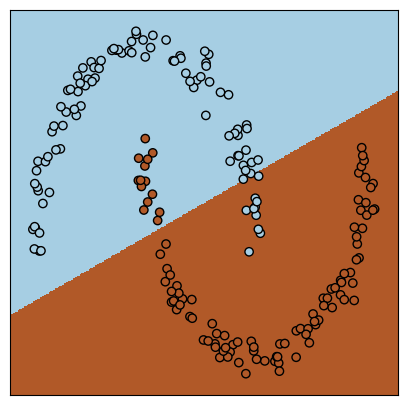

In [90]:
_, ax = plt.subplots (figsize=(5,5))

# Put the result into a color plot
plt.pcolormesh( h_grid , v_grid , predictions , cmap='Paired')

ax.scatter( X_test[:,0] , X_test[:,1] , c = np.argmax(y_test, axis=1) , edgecolors='k', cmap='Paired')

# ax.set_xlim(h_grid.min()-.1, h_grid.max()+.1)
# ax.set_ylim(v_grid.min()-.1, v_grid.max()+.1)

ax.set_xticks(())
ax.set_yticks(())